In [1]:
from tierpsy.features.tierpsy_features import timeseries_feats_columns, ventral_signed_columns

import pandas as pd
from tqdm import tqdm, tqdm_notebook
import numpy as np
import numba
from scipy.stats import entropy
from itertools import combinations
import warnings
from textwrap import wrap

import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages

from scipy.special import comb
import pickle

from pathlib import Path
from collections import defaultdict

all_feats = timeseries_feats_columns
all_feats = [x for x in all_feats if not 'path_curvature' in x]

def digitize_features(centered_data, ybins):
    digitized_data = {}
    for feat in all_feats:
        ybin = ybins[feat]
        bot, top = ybin[0], ybin[-1]
        dat = np.clip(centered_data[feat], bot + 1e-6, top - 1e-6)
        
        yedges = np.concatenate([ybin - (ybin[1]-ybin[0])/2, [np.inf]])
        digitized = np.digitize(dat, yedges) -1
        
        #flag bad rows with -1
        counts[np.isnan(dat)] = -1
        digitized_data[feat] = digitized
    
    return digitized_data

@numba.jit(nopython=True)
def calc_histogram_2d(x_digit, y_digit, n_x, n_y):
    H = np.zeros((n_y, n_x), np.int32)
    for ii in range(y_digit.size):
        x = x_digit[ii]
        y = y_digit[ii]
        if y >= 0:
            H[y, x] += 1
    return H

In [2]:
def group_by_timebin(df, xbins, reduce_func = np.nanmedian, bootstraping_size = 100):

    ts_data = df.to_records(index = False)

    w_groups_index = defaultdict(list)
    for ii, w in enumerate(ts_data['worm_index']):
        w_groups_index[w].append(ii)


    w_groups = {}
    worms_in_time = defaultdict(list)
    for w, w_inds in w_groups_index.items():
        w_data = ts_data[w_inds]

        t_groups = defaultdict(list)
        for ii, t in enumerate(w_data['time_binned']):
            t_groups[t].append(ii)

        w_groups[w] = {}
        for t, t_inds in t_groups.items():
            w_groups[w][t] = w_data[t_inds]
            worms_in_time[t].append(w)

    def get_average_data(worms2use_dict):        
        avg_data = []
        for t in range(len(xbins)):
            w_data = []
            
            worms2use = worms2use_dict[t]
            for w in worms2use:
                if t in w_groups[w]:
                    w_data.append(w_groups[w][t])
            if w_data:
                w_data = np.concatenate(w_data)
                dd = [reduce_func(w_data[x]) for x in w_data.dtype.names]
            else:
                dd = [np.nan for _ in ts_data.dtype.names]
            avg_data.append(dd)

        return avg_data

    avg_data = get_average_data(worms_in_time)
    df_stat = pd.DataFrame(avg_data, columns = df.columns, index = xbins)
    
    
    bootstraping_data = []
    for _ in range(bootstraping_size):
        worms2use_dict = {}
        for t, available_worms in worms_in_time.items():
            worms2use_dict[t] = np.random.choice(available_worms, len(available_worms), replace=True)
        dat = get_average_data(worms2use_dict)
        bootstraping_data.append(dat)

    bootstraping_data = np.array(bootstraping_data)
    
    err_low, err_high = np.percentile(bootstraping_data, [5, 95], axis=0)
    df_err_low = pd.DataFrame(err_low, columns = df.columns, index = xbins)
    df_err_high = pd.DataFrame(err_high, columns = df.columns, index = xbins)
    
    #err = np.std(bootstraping_data, axis=0)
    #df_err = pd.DataFrame(err, columns = df.columns, index = xbins)
    
    return df_stat, (df_err_low, df_err_high)





In [3]:
def IQR(x):
    q = x.quantile([0.25, 0.75])
    inter_q = q.loc[0.75] - q.loc[0.25]
    return inter_q

def read_data(src_file, 
              events_dir, 
              strains2read, 
              xbins = np.arange(-5, 5.1, 0.5), 
              qbins = (0.01, 0.99),
              fps = 25,
              abs_ventral_features = True
             ):
    
    xedges = np.concatenate([xbins - (xbins[1]-xbins[0])/2, [np.inf]])
    
    files_data = pd.read_pickle(src_file)
    strain_basenames = {s : x for s,x in files_data.groupby('strain')}
    
    strains_data = {}
    strain_avg_data = {}
    bin_ranges_l = []
    for istrain, strain in enumerate(tqdm_notebook(strains2read)):
        basenames = strain_basenames[strain]['basename'].values
        
        all_df = []
        
        tot_worms = 0
        for bn in basenames:
            ts_file = events_dir / f'{bn}_timeseries.pkl'
            if ts_file.exists():
                df_ts = pd.read_pickle(ts_file)
                
                w_inds = np.unique(df_ts['worm_index'].values)
                w_mapping = {k : (i + tot_worms) for i,k in enumerate(w_inds)}
                tot_worms += len(w_inds)
                
                df_ts['worm_index_original'] = df_ts['worm_index']
                df_ts['worm_index'] = df_ts['worm_index'].map(w_mapping)
                
                all_df.append(df_ts)
                
        all_df = pd.concat(all_df)
    
        if abs_ventral_features:
            feats2abs = [x for x in ventral_signed_columns if x in all_df]
            all_df[feats2abs] = all_df[feats2abs].abs()
            
        

        all_df['time_centered'] = all_df['timestamp_centered']/fps
        valid = (all_df['time_centered']>=xbins[0]) & (all_df['time_centered']<=xbins[-1])
        all_df = all_df[valid].copy()
        all_df['time_binned'] = np.digitize(all_df['time_centered'], xedges) -1
        
        strains_data[strain] = all_df
        #df_g = all_df.groupby('time_binned')
        #df_means = df_g.agg(['median', 'count'])
        
        
        df_grouped = group_by_timebin(all_df, xbins)
        strain_avg_data[strain] = df_grouped
        
        q = all_df.quantile(qbins)
        bin_ranges_l.append(q)


    q_bot = [q.loc[qbins[0]] for q in bin_ranges_l]
    q_bot = pd.concat(q_bot, axis=1).min(axis=1)

    q_top = [q.loc[qbins[1]] for q in bin_ranges_l]
    q_top = pd.concat(q_top, axis=1).max(axis=1)

    bin_ranges = pd.concat((q_bot, q_top), axis=1)
    bin_ranges.columns = ['bot', 'top']
    
    
    return strains_data, strain_avg_data, bin_ranges


In [4]:
def plot_features(strains_data,
                  strain_avg_data,
                  bin_ranges,
                  feats2plot = ['length'], 
                  num_ybins = 15, 
                  xbins = np.arange(-10, 10.1, 1),
                  min_valid_counts = 250,
                  save_name = None
                 ):

    figs2return = []
    
    num_xbins = len(xbins)
    xticks = [0.5, num_xbins//2 - .5, num_xbins-0.5]
    xtickslabels = [int(xbins[0]), 0, int(xbins[-1])]
    yticks = [0.5, num_ybins//2 - .5, num_ybins-0.5]
    
    figsize = (22, 2)
    
    strain_titles = {}
    for strain, strain_ts_data in strains_data.items():
        s_g = strain_ts_data[['worm_index','time_centered']].groupby('time_centered')
        n_events = [len(dat['worm_index'].unique()) for t, dat in s_g]
        strain_titles[strain] = f'{strain}={min(n_events)}-{max(n_events)}'
    
    
    
    for feat in tqdm_notebook(feats2plot):
        feat_label = '\n'.join(wrap(feat.replace('_', ' ').title(), 25))
        
        y_bot, y_top = bin_ranges.loc[feat].values
        ybins = np.linspace(y_bot, y_top, num_ybins)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fig_hist, axs = plt.subplots(1, len(strains_data), figsize = figsize, sharex = True, sharey = True)
            figs2return.append(fig_hist)
            
        for ax, (strain, strain_ts_data) in zip(axs, strains_data.items()):
            feat_data = strain_ts_data[feat]

            dat = np.clip(feat_data, y_bot + 1e-6, y_top - 1e-6)
            y_digit = np.digitize(dat, ybins)
            x_digit = strain_ts_data['time_binned'].values

            assert y_digit.size == x_digit.size
            counts = calc_histogram_2d(x_digit, y_digit, num_xbins, num_ybins)
            
            N = counts.sum(axis=0)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                H = counts/N
            H[:, N<min_valid_counts] = np.nan

            ax.imshow(H, aspect = 'auto', origin='lower')
            ax.set_title(strain_titles[strain])

            ax.set_xticks(xticks)
            ax.set_xticklabels(xtickslabels)
        axs[0].set_ylabel(feat_label)



        ytickslabels = [ybins[0], ybins[num_ybins//2] , ybins[-1]]
        ytickslabels = [f'{x:.2f}' for x in ytickslabels]

        axs[0].set_yticks(yticks)
        axs[0].set_yticklabels(ytickslabels)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fig_avg, axs = plt.subplots(1, len(strain_avg_data), figsize = figsize, sharex = True, sharey = True)
            figs2return.append(fig_avg)

        for ax, (strain, (df_stat, (df_err_low, df_err_high))) in zip(axs, strain_avg_data.items()):
            yy = df_stat[feat].values.copy()
            er = df_err[feat].values.copy()

            ax.plot(xbins, yy)
            ax.fill_between(xbins, yy - er, yy + er, alpha=0.5)
            ax.set_title(strain_titles[strain])

            #yy = data_avg[feat][stat_type].values.copy()
            #invalid = data_avg[feat]['count'].values < min_valid_counts
            #yy[invalid] = np.nan
            #ax.plot(xbins, yy)
            #ax.set_title(strain_titles[strain])

        axs[0].set_ylabel(feat_label)

        ylims = ax.get_ylim()
        for ax in axs:
            ax.plot((0,0), ylims, ':k')
    
    if save_name is not None:
        save_name.parent.mkdir(exist_ok = True, parents = True)
        with PdfPages(save_name) as pdf:
            for fig in figs2return:
                pdf.savefig(fig)
        
    return figs2return

In [5]:
#bn = 'worm-eggs-adam-masks+Feggs+roi128+hard-neg-5_clf+unet-simple_maxlikelihood_20190808_151948_adam_lr0.000128_wd0.0_batch64'
#events_dir = Path.home() / 'OneDrive - Nexus365/worms/eggs/egg_laying' / bn

bn = 'AUG_worm-eggs-adam-masks+Feggs+roi128+hard-neg-5_clf+unet-simple_maxlikelihood_20190808_151948_adam_lr0.000128_wd0.0_batch64'
events_dir = Path.home() / 'workspace/WormData/egg_laying/plates/predictions/' / bn

src_file = events_dir / 'files_data.pkl'
histograms_dir = events_dir / 'histograms'

DIVERGENT_SET = ['CB4856', 'N2',  'DL238', 'CX11314', 'MY23', 'JU775', 'JT11398',
       'EG4725', 'LKC34', 'ED3017', 'MY16', 'JU258']

xbins_short = np.arange(-10, 10.1, 1)
short_data = read_data(src_file, events_dir, DIVERGENT_SET, xbins = xbins_short);

xbins_long = np.arange(-120, 120.1, 10)
long_data = read_data(src_file, events_dir, DIVERGENT_SET, xbins = xbins_long);


NameError: name 'df_err' is not defined

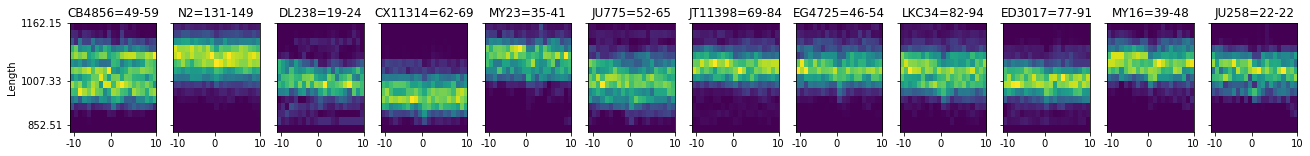

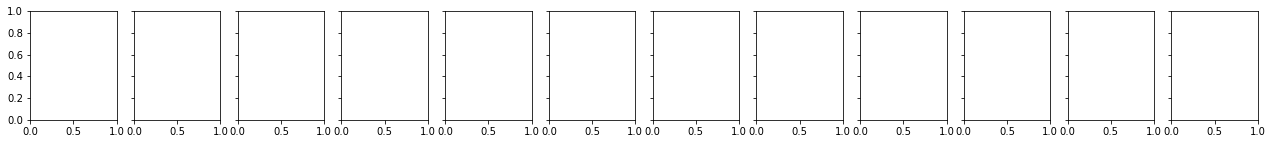

In [6]:
feats2plot = ['length', 'd_length']
save_name = histograms_dir / 'length-short.pdf'
plot_features(*short_data, feats2plot = feats2plot, xbins = xbins_short, save_name = save_name);

save_name = histograms_dir / 'length-long.pdf'
plot_features(*long_data, feats2plot = feats2plot, xbins = xbins_long, save_name = save_name);


feats2plot = ['speed', 'd_speed']
save_name = histograms_dir / 'speed-short.pdf'
plot_features(*short_data, feats2plot = feats2plot, xbins = xbins_short, save_name = save_name);

save_name = histograms_dir / 'speed-long.pdf'
plot_features(*long_data, feats2plot = feats2plot, xbins = xbins_long, save_name = save_name);


In [ ]:
feats2plot = ['relative_to_head_base_radial_velocity_head_tip', 
              'relative_to_neck_radial_velocity_head_tip', 
              'relative_to_body_radial_velocity_head_tip', 
              'relative_to_body_radial_velocity_neck', 
              'relative_to_body_radial_velocity_hips', 
              'relative_to_body_radial_velocity_tail_tip', 
              'relative_to_hips_radial_velocity_tail_tip', 
              'relative_to_tail_base_radial_velocity_tail_tip']


save_name = histograms_dir / 'radial_velocity-short.pdf'
plot_features(*short_data, feats2plot = feats2plot, xbins = xbins_short, save_name = save_name);



In [ ]:
# feats2plot = sorted([x for x in all_feats if 'curvature_std' in x and not x.startswith('d')])
# feats2plot = ['curvature_head',
#               'curvature_neck',
#               'curvature_midbody',
#               'curvature_hips', 
#               'curvature_tail',
              
#               'curvature_mean_head', 
#               'curvature_mean_neck', 
#               'curvature_mean_midbody',
#               'curvature_mean_hips',
#               'curvature_mean_tail',
              
#               'curvature_std_head', 
#               'curvature_std_neck', 
#               'curvature_std_midbody',
#               'curvature_std_hips',
#               'curvature_std_tail'
#              ]
feats2plot = ['curvature_head', 'curvature_std_midbody']
save_name = histograms_dir / 'curvature-short.pdf'
plot_features(*short_data, feats2plot = feats2plot, xbins = xbins_short, save_name = save_name);

save_name = histograms_dir / 'curvature-long.pdf'
plot_features(*long_data, feats2plot = feats2plot, xbins = xbins_long, save_name = save_name);

In [ ]:
feats2plot = ['angular_velocity', 
              'relative_to_neck_angular_velocity_head_tip', 
              'relative_to_body_angular_velocity_head_tip', 
              'relative_to_body_angular_velocity_neck', 
              'relative_to_body_angular_velocity_hips', 
              'relative_to_body_angular_velocity_tail_tip', 
              'relative_to_hips_angular_velocity_tail_tip',
              ]

save_name = histograms_dir / 'angular_velocity-short.pdf'
plot_features(*short_data, feats2plot = feats2plot, xbins = xbins_short, save_name = save_name);

save_name = histograms_dir / 'angular_velocity-long.pdf'
plot_features(*long_data, feats2plot = feats2plot, xbins = xbins_long, save_name = save_name);


In [ ]:
feats2plot = ['dist_from_food_edge']#, 'orientation_food_edge']
save_name = histograms_dir / 'food-short.pdf'
plot_features(*short_data, feats2plot = feats2plot, xbins = xbins_short, save_name = save_name);

save_name = histograms_dir / 'food-long.pdf'
plot_features(*long_data, feats2plot = feats2plot, xbins = xbins_long, save_name = save_name);

In [ ]:
feats2plot = ['width_midbody', 
              ]

save_name = histograms_dir / 'midbody-short.pdf'
plot_features(*short_data, feats2plot = feats2plot, xbins = xbins_short, save_name = save_name);

save_name = histograms_dir / 'midbody-long.pdf'
plot_features(*long_data, feats2plot = feats2plot, xbins = xbins_long, save_name = save_name);